# Univariate MLP Time Series

In [33]:
import pandas as pd

df_2021 = pd.read_csv('data/2021.txt', sep = ";", usecols = [2])
df_2021

,Energy(MWh)
0,0.90
1,0.93
2,0.86
3,0.88
4,0.87
...,...
360,2.19
361,2.16
362,2.22
363,2.23


In [49]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 364
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Energy(MWh)  352 non-null    float64
dtypes: float64(1)
memory usage: 5.5 KB


### Drop NaN rows

In [50]:
df_2021.dropna(inplace = True)

## Train Test Splits

In [51]:
X = df_2021.values
size_test = .10
size_test = round(len(X) * size_test)
X_train, X_test = X[0:len(X) - size_test], X[len(X) - size_test:]

In [52]:
X_train.shape, X_test.shape 

((317, 1), (35, 1))

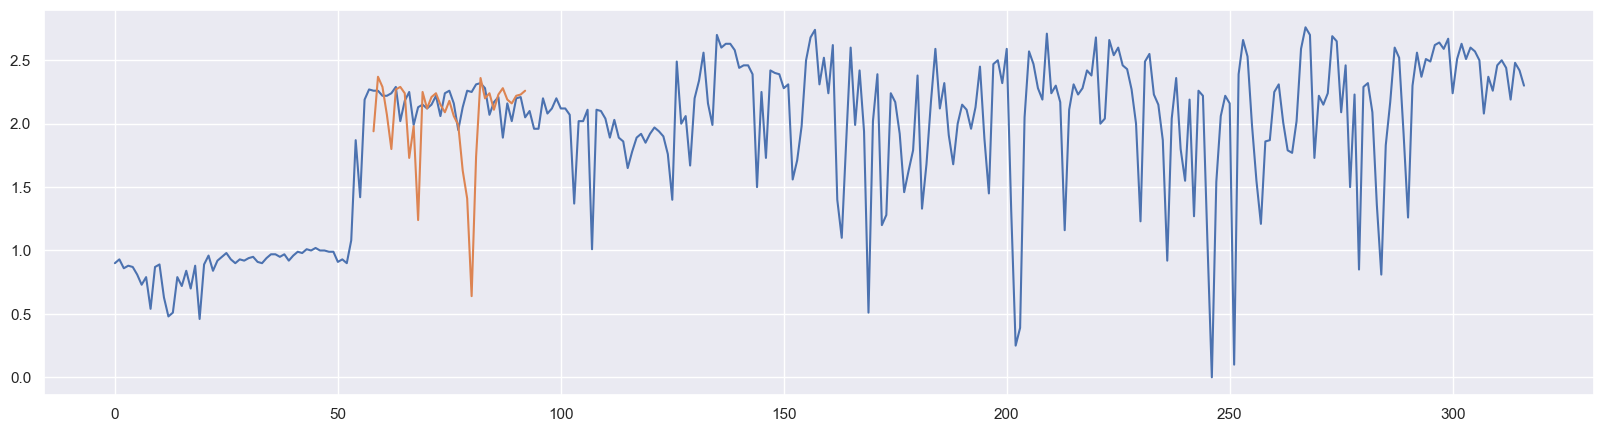

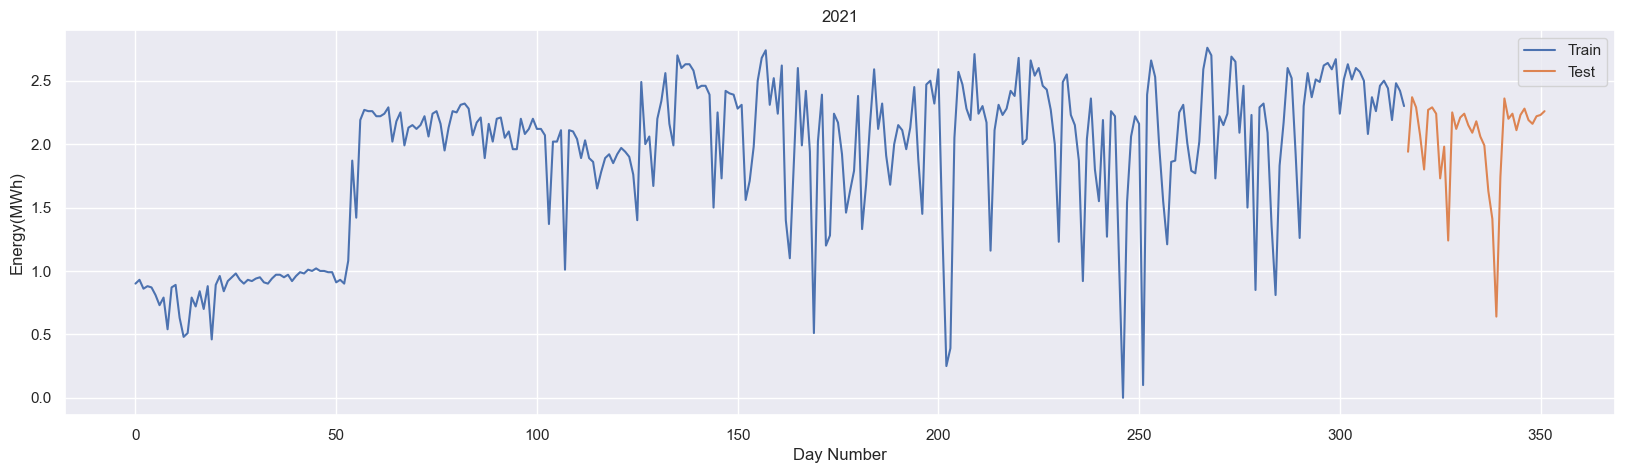

In [53]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

fig = plt.figure(figsize=(20, 5))

X_train_plot = X_train
X_test_plot = X_test

plt.plot(np.arange(0, len(X) - size_test), X_train_plot, label = "Train")
plt.plot(np.arange(len(X) - size_test, len(X)), X_test_plot, label = "Test")
plt.title("2021")
plt.xlabel("Day Number")
plt.ylabel("Energy(MWh)")
plt.legend()
plt.show()

## Create sequence features 

In [54]:
from utils import split_sequence

n_steps = 3
X_train, y_train = split_sequence(X_train.flatten(), n_steps)
X_train[0:10], y_train[0:10], X_train.shape

(array([[0.9 , 0.93, 0.86],
        [0.93, 0.86, 0.88],
        [0.86, 0.88, 0.87],
        [0.88, 0.87, 0.81],
        [0.87, 0.81, 0.73],
        [0.81, 0.73, 0.79],
        [0.73, 0.79, 0.54],
        [0.79, 0.54, 0.87],
        [0.54, 0.87, 0.89],
        [0.87, 0.89, 0.63]]),
 array([0.88, 0.87, 0.81, 0.73, 0.79, 0.54, 0.87, 0.89, 0.63, 0.48]),
 (314, 3))

# Model

In [55]:
import tensorflow as tf
from utils import plot_history

def create_train_model(X, y, hidden_units = 10, epochs = 10, verbose = False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hidden_units, activation='relu', input_dim = n_steps))
    model.add(tf.keras.layers.Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)

    model.compile(
        loss='mse',
        metrics=[tf.keras.metrics.MeanSquaredError()],
        optimizer = opt
    )

    history = model.fit(
        X,
        y,
        validation_split = .10,
        epochs = epochs,
        verbose = False
    )

    if verbose:
        print(model.summary())
        plot_history(history)
        
    return model 

In [56]:
model = create_train_model(X_train, y_train, hidden_units = 100, epochs = 200, verbose = False)

# Testing

In [57]:
import numpy as np

X_test, y_test = split_sequence(X_test.flatten(), n_steps)

In [58]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test, verbose = False)
print("Validation MSE: ", mean_squared_error(y_test, y_pred))

Validation MSE:  0.15330743098150273


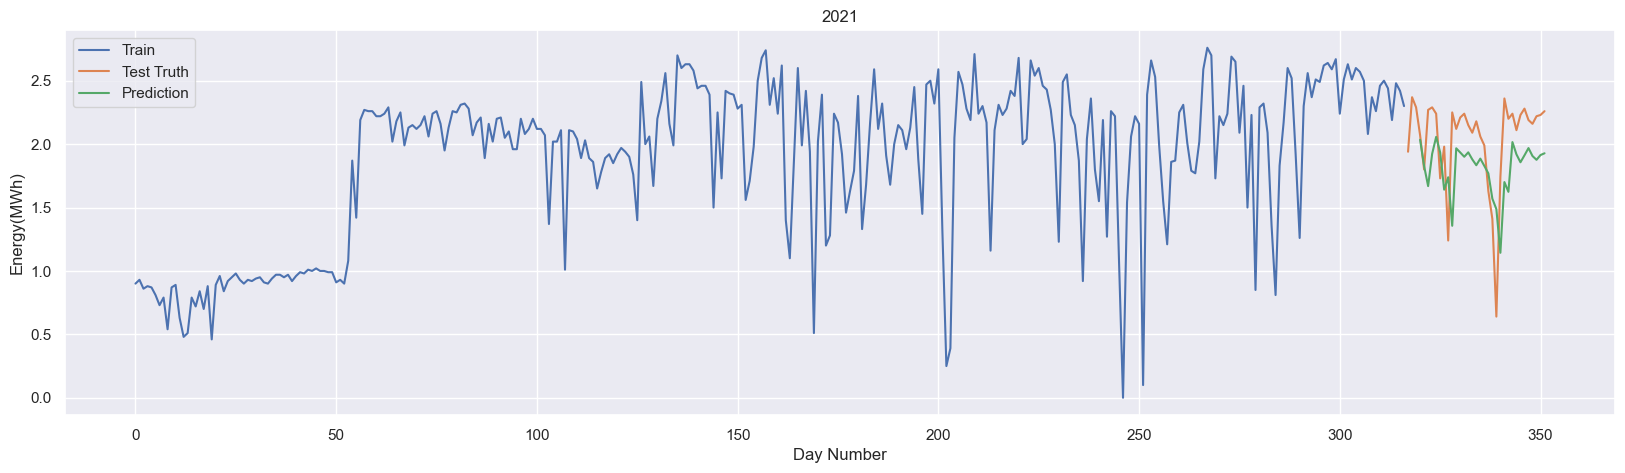

In [59]:
fig = plt.figure(figsize=(20, 5))

plt.plot(X_train_plot, label = "Train")
plt.plot(np.arange(len(X) - size_test, len(X)), X_test_plot, label = "Test Truth")
plt.plot(np.arange(n_steps + len(X) - size_test, len(X)), y_pred, label = "Prediction")
plt.title("2021")
plt.xlabel("Day Number")
plt.ylabel("Energy(MWh)")
plt.legend()
plt.show()

## Testing on 2022

In [60]:
df_2022 = pd.read_csv("data/2022.csv", sep=";", usecols=[2])
df_2022

,Energy(MWh)
0,2.34
1,2.32
2,2.19
3,1.93
4,2.20
...,...
111,2.65
112,2.61
113,2.75
114,2.24


Validation MSE:  0.2629167028870777


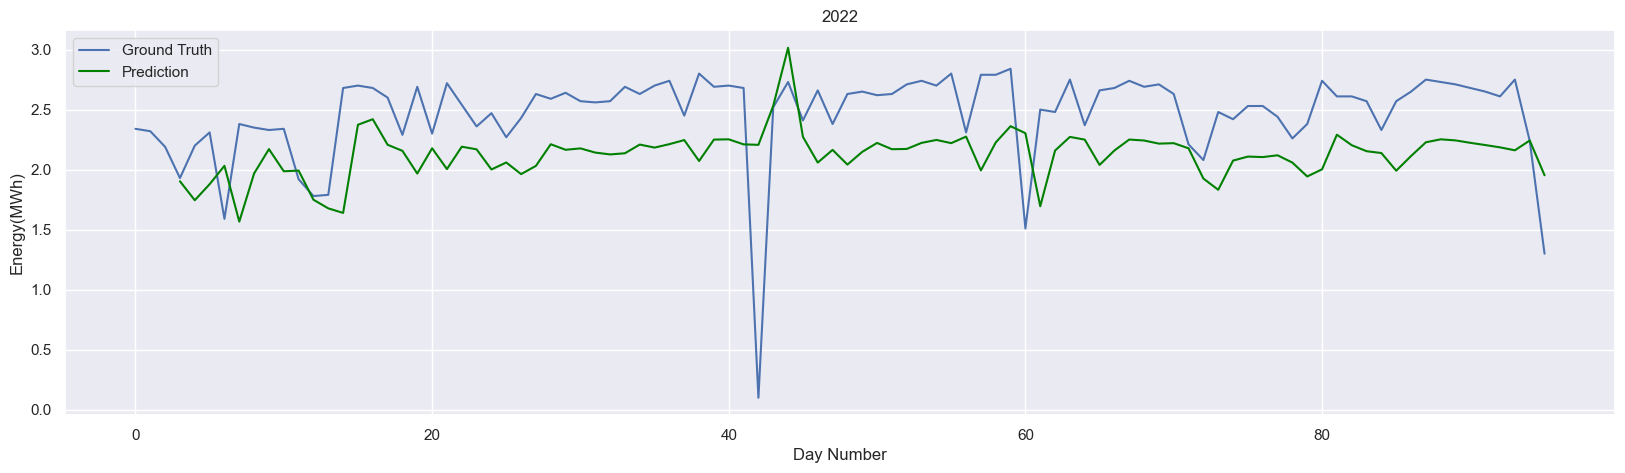

In [68]:
df_2022.dropna(inplace = True)
X_raw = df_2022.values
X, y = split_sequence(X_raw.flatten(), n_steps)

y_pred = model.predict(X, verbose = False)
print("Test MSE: ", mean_squared_error(y, y_pred))

fig = plt.figure(figsize=(20, 5))
plt.plot(X_raw, label = "Ground Truth")
plt.plot(np.arange(n_steps, len(X_raw)), y_pred, label = "Prediction", color = "green")
plt.title("2022")
plt.xlabel("Day Number")
plt.ylabel("Energy(MWh)")
plt.legend()
plt.show()

## GridSearch

Test MSE:  0.1576
Test MSE:  0.1901
Test MSE:  0.1963


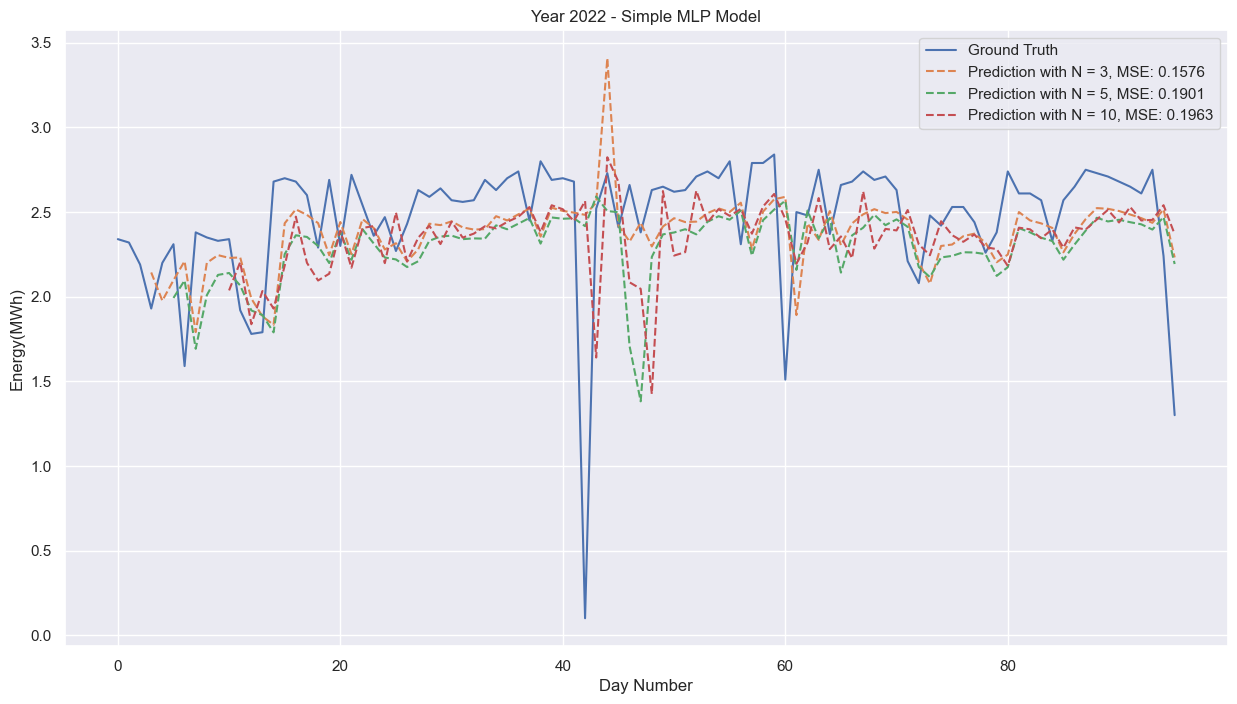

In [104]:
line_styles = ['dotted', 'dashed', 'dashdot']

n_steps_list = [3, 5, 10]

# Plot results
fig = plt.figure(figsize=(15, 8))
plt.plot(df_2022.values, label = "Ground Truth")

for i, n_steps in enumerate(n_steps_list):

    # Train on 2021
    X_train = df_2021.values
    X_train, y_train = split_sequence(X_train.flatten(), n_steps)
    model = create_train_model(X_train, y_train, hidden_units = 100, epochs = 200, verbose = False)

    # Test on 2022
    X_test = df_2022.values
    X_test, y_test = split_sequence(X_test.flatten(), n_steps)
    y_pred = model.predict(X_test, verbose = False)

    # Evaluation
    mse =  np.round(mean_squared_error(y_test, y_pred), 4)
    print("Test MSE: ", mse)

    label = f"Prediction with N = {n_steps}, MSE: {mse}"
    plt.plot(np.arange(n_steps, len(df_2022.values)), y_pred, label = label, ls = 'dashed')

plt.title(f"Year 2022 - Simple MLP Model")
plt.xlabel("Day Number")
plt.ylabel("Energy(MWh)")
plt.legend(loc = "best")
plt.savefig('results/Year 2022 Simple MLP Model.png')
plt.show()